In [1]:
%pip install qiskit 
%pip install qiskit-aer 
%pip install pylatexenc 
%pip install qiskit-ibm-runtime 
%pip install qiskit-ibm-provider 

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Implementing Grover's algorithm for the case of 5 qubits with the winning state of |w⟩=|10110⟩

In [237]:
#initialization
import matplotlib.pyplot as plt
import numpy as np

# importing Qiskit
from qiskit import QuantumCircuit, transpile, ClassicalRegister, QuantumRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_state_city

# import basic plot tools
from qiskit.visualization import plot_histogram


In [123]:
def naive_oracle(qc: QuantumCircuit, ctrl_state: str, total_qubit_count: int, functional_qubit_count: int):
    auxilary_bit_index = total_qubit_count - 1
    functional_qubit_indexes = list(range(functional_qubit_count))
    qc.mcx(functional_qubit_indexes, auxilary_bit_index, ctrl_state=ctrl_state)

In [120]:
def naive_diffuser(qc: QuantumCircuit, functional_qubit_count: int):
    for qubit in range(functional_qubit_count):
        qc.h(qubit)
    
    for qubit in range(functional_qubit_count):
        qc.x(qubit)
    
    control_qubit_indexes = list(range(functional_qubit_count - 1))
    final_functional_qubit_index = functional_qubit_count - 1

    qc.h(final_functional_qubit_index)
    qc.mcx(control_qubit_indexes, final_functional_qubit_index)
    qc.h(final_functional_qubit_index)
    
    for qubit in range(functional_qubit_count):
        qc.x(qubit)
    
    for qubit in range(functional_qubit_count):
        qc.h(qubit)

In [ ]:
def naive_grover(ctrl_state: str) -> QuantumCircuit:
    functional_qubit_count = ctrl_state.__len__()
    auxilary_qubit_count = 1
    total_qubit_count = functional_qubit_count + auxilary_qubit_count
    classical_bit_count = functional_qubit_count

    iteration_count = int(np.sqrt(2**functional_qubit_count))

    qc=QuantumCircuit(total_qubit_count, classical_bit_count)

    qc.x(functional_qubit_count)

    for i in range(total_qubit_count):
        qc.h(i)

    for i in range(iteration_count):
        naive_oracle(qc, ctrl_state, total_qubit_count, functional_qubit_count)
        naive_diffuser(qc, functional_qubit_count)

    qc.measure(range(functional_qubit_count), range(classical_bit_count))
    return qc

In [208]:
qc = naive_grover('10110')
qc.draw()

┌───┐          ┌───┐┌───┐          ┌───┐┌───┐          ┌───┐┌───┐     »
q_0: ┤ H ├───────o──┤ H ├┤ X ├───────■──┤ X ├┤ H ├───────o──┤ H ├┤ X ├─────»
     ├───┤       │  ├───┤├───┤       │  ├───┤├───┤       │  ├───┤├───┤     »
q_1: ┤ H ├───────■──┤ H ├┤ X ├───────■──┤ X ├┤ H ├───────■──┤ H ├┤ X ├─────»
     ├───┤       │  ├───┤├───┤       │  ├───┤├───┤       │  ├───┤├───┤     »
q_2: ┤ H ├───────■──┤ H ├┤ X ├───────■──┤ X ├┤ H ├───────■──┤ H ├┤ X ├─────»
     ├───┤       │  ├───┤├───┤       │  ├───┤├───┤       │  ├───┤├───┤     »
q_3: ┤ H ├───────o──┤ H ├┤ X ├───────■──┤ X ├┤ H ├───────o──┤ H ├┤ X ├─────»
     ├───┤       │  ├───┤├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐  │  ├───┤├───┤┌───┐»
q_4: ┤ H ├───────■──┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├──■──┤ H ├┤ X ├┤ H ├»
     ├───┤┌───┐┌─┴─┐└───┘└───┘└───┘└───┘└───┘└───┘└───┘┌─┴─┐└───┘└───┘└───┘»
q_5: ┤ X ├┤ H ├┤ X ├───────────────────────────────────┤ X ├───────────────»
     └───┘└───┘└───┘                                   └───┘               »
c: 5/══════════════════════════════════════════════════════════════════════»
                                                                           »
«          ┌───┐┌───┐          ┌───┐┌───┐          ┌───┐┌───┐          ┌───┐»
«q_0: ──■──┤ X ├┤ H ├───────o──┤ H ├┤ X ├───────■──┤ X ├┤ H ├───────o──┤ H ├»
«       │  ├───┤├───┤       │  ├───┤├───┤       │  ├───┤├───┤       │  ├───┤»
«q_1: ──■──┤ X ├┤ H ├───────■──┤ H ├┤ X ├───────■──┤ X ├┤ H ├───────■──┤ H ├»
«       │  ├───┤├───┤       │  ├───┤├───┤       │  ├───┤├───┤       │  ├───┤»
«q_2: ──■──┤ X ├┤ H ├───────■──┤ H ├┤ X ├───────■──┤ X ├┤ H ├───────■──┤ H ├»
«       │  ├───┤├───┤       │  ├───┤├───┤       │  ├───┤├───┤       │  ├───┤»
«q_3: ──■──┤ X ├┤ H ├───────o──┤ H ├┤ X ├───────■──┤ X ├┤ H ├───────o──┤ H ├»
«     ┌─┴─┐├───┤├───┤┌───┐  │  ├───┤├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐  │  ├───┤»
«q_4: ┤ X ├┤ H ├┤ X ├┤ H ├──■──┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├──■──┤ H ├»
«     └───┘└───┘└───┘└───┘┌─┴─┐└───┘└───┘└───┘└───┘└───┘└───┘└───┘┌─┴─┐└───┘»
«q_5: ────────────────────┤ X ├───────────────────────────────────┤ X ├─────»
«                         └───┘                                   └───┘     »
«c: 5/══════════════════════════════════════════════════════════════════════»
«                                                                           »
«     ┌───┐          ┌───┐┌───┐          ┌───┐┌───┐          ┌───┐┌───┐     
«q_0: ┤ X ├───────■──┤ X ├┤ H ├───────o──┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────
«     ├───┤       │  ├───┤├───┤       │  ├───┤├───┤       │  ├───┤├───┤     
«q_1: ┤ X ├───────■──┤ X ├┤ H ├───────■──┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────
«     ├───┤       │  ├───┤├───┤       │  ├───┤├───┤       │  ├───┤├───┤     
«q_2: ┤ X ├───────■──┤ X ├┤ H ├───────■──┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────
«     ├───┤       │  ├───┤├───┤       │  ├───┤├───┤       │  ├───┤├───┤     
«q_3: ┤ X ├───────■──┤ X ├┤ H ├───────o──┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────
«     ├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐  │  ├───┤├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐
«q_4: ┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├──■──┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├
«     └───┘└───┘└───┘└───┘└───┘└───┘┌─┴─┐└───┘└───┘└───┘└───┘└───┘└───┘└───┘
«q_5: ──────────────────────────────┤ X ├───────────────────────────────────
«                                   └───┘                                   
«c: 5/══════════════════════════════════════════════════════════════════════
«

# Simulating Grover's algorithm with noise

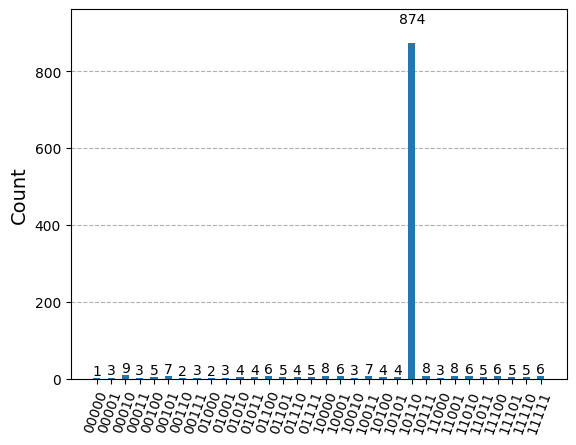

In [141]:
qc = naive_grover('10110')

aer_sim = AerSimulator(method='statevector')
qobj = transpile(qc, aer_sim)
result = aer_sim.run(qobj).result()

counts = result.get_counts()
plot_histogram(counts)


In [275]:
def pauli_oracle(qc: QuantumCircuit, ctrl_state: str):
    qubit_count = ctrl_state.__len__()
    is_qubit_count_odd = qubit_count % 2 != 0

    changed_qubits = [i for i in range(qubit_count) if ctrl_state[i] == "0"]

    for i in changed_qubits:
        qc.x(i)

    qc.barrier()

    for i in range(1, qubit_count):
        qc.cz(i, 0)

    if (is_qubit_count_odd):
        qc.cz(1, 0)

    qc.barrier()
    
    for i in changed_qubits:
        qc.x(i)


In [279]:
def simple_grover(ctrl_state: str) -> QuantumCircuit:
    qubit_count = ctrl_state.__len__()
    classical_bit_count = qubit_count
    
    qc=QuantumCircuit(qubit_count, classical_bit_count)
    qc.h(range(qubit_count))
    qc.barrier()
    pauli_oracle(qc, ctrl_state)
    qc.barrier()
    return qc
    

In [280]:
qc = simple_grover("10110")
qc.draw()

┌───┐ ░       ░                 ░       ░ 
q_0: ┤ H ├─░───────░──■──■──■──■──■──░───────░─
     ├───┤ ░ ┌───┐ ░  │  │  │  │  │  ░ ┌───┐ ░ 
q_1: ┤ H ├─░─┤ X ├─░──■──┼──┼──┼──■──░─┤ X ├─░─
     ├───┤ ░ └───┘ ░     │  │  │     ░ └───┘ ░ 
q_2: ┤ H ├─░───────░─────■──┼──┼─────░───────░─
     ├───┤ ░       ░        │  │     ░       ░ 
q_3: ┤ H ├─░───────░────────■──┼─────░───────░─
     ├───┤ ░ ┌───┐ ░           │     ░ ┌───┐ ░ 
q_4: ┤ H ├─░─┤ X ├─░───────────■─────░─┤ X ├─░─
     └───┘ ░ └───┘ ░                 ░ └───┘ ░ 
c: 5/══════════════════════════════════════════

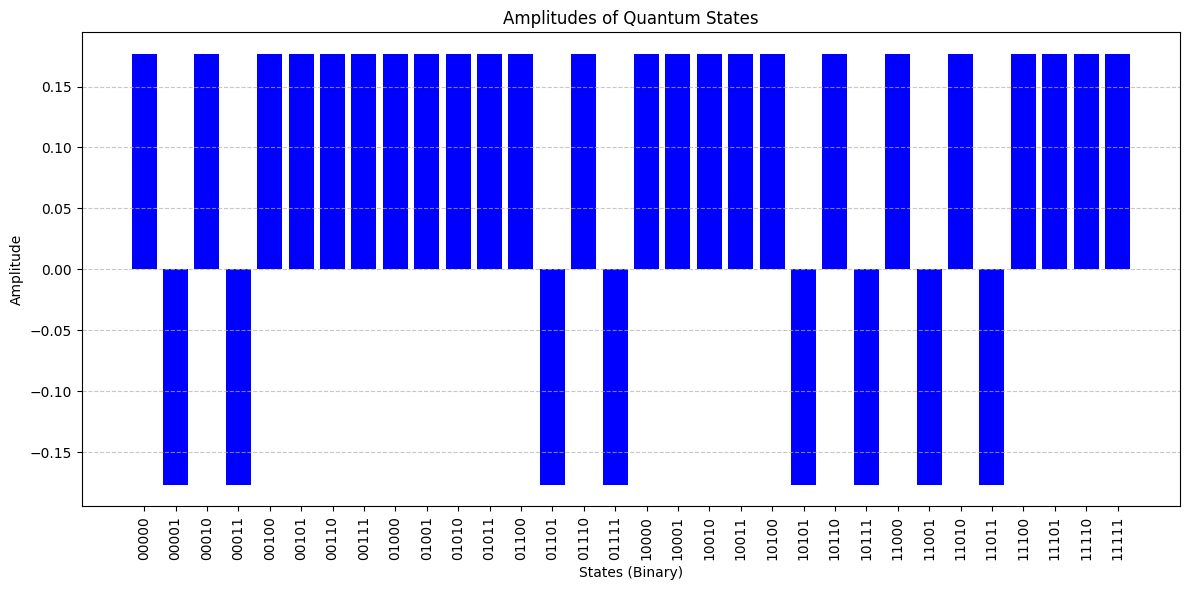

In [281]:

qc.save_statevector()
aer_sim = AerSimulator(method='statevector')
qobj = transpile(qc, aer_sim)
result = aer_sim.run(qobj).result()
state_vector = result.get_statevector()
real_parts = state_vector.data.real
state_amplitudes = real_parts[:32]


num_states = len(state_amplitudes)
binary_labels = [f"{i:05b}" for i in range(num_states)] 


plt.figure(figsize=(12, 6))
plt.bar(binary_labels, state_amplitudes, color='blue')


plt.xlabel('States (Binary)')
plt.ylabel('Amplitude')
plt.title('Amplitudes of Quantum States')
plt.xticks(rotation=90) 
plt.grid(axis='y', linestyle='--', alpha=0.7)


plt.tight_layout() 
plt.show()

## Run the circuit on IBM quantum (IBM Q)

### Preparation for accessing IBM Q: store your IBM Q credential on your local computer
Step 1: Create an IBM Quantum account or log in to your existing account (visit the [IBM Quantum login page](https://quantum-computing.ibm.com/login)). <br>
Step 2: Copy your API token (or optionally regenerate one) from your [IBM Quantum account page](https://quantum-computing.ibm.com/account)
<br>
Step 3: Run the funciton IBMProvider.save_account(token='MY_API_TOKEN') below (replace API_Token with your copied API toke).
<br>
For more information: https://pypi.org/project/qiskit-ibm-provider/

In [ ]:
#!pip install qiskit_ibm_provider

## Run the circuit on a simulator simulating a quantum device (QPU)
https://docs.quantum.ibm.com/guides/local-testing-mode


In [78]:
# Run our circuit on the backend.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler

# Replace 'YOUR_API_TOKEN' with your actual IBM Quantum API token
token='dfda9ea30f8353753911497de4aaec89e6e4f3a5e7a88149c16fbc2983ed9c8c93cbc6a8c7385930d2af8383b71cc0d6c613562e3d3a4cdc6c05302da8a92b0b'
QiskitRuntimeService.save_account(
  token=token,
  channel="ibm_quantum", # `channel` distinguishes between different account types
  overwrite=True
)

service = QiskitRuntimeService()

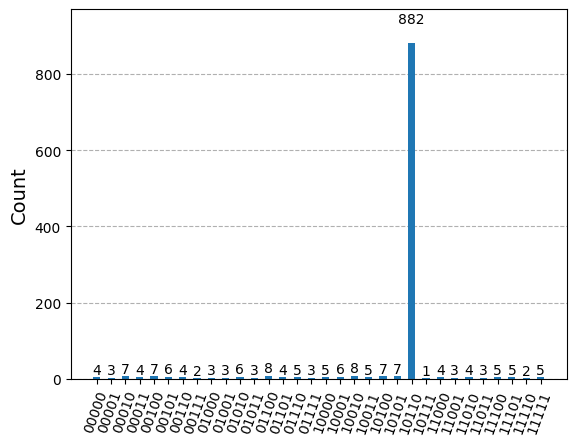

In [143]:
qc = naive_grover('10110')

aer_sim = AerSimulator(method='statevector')
qobj = transpile(qc, aer_sim)
result = aer_sim.run(qobj).result()

counts = result.get_counts()
plot_histogram(counts)

{'001': 339, '101': 2162, '000': 260, '111': 291, '100': 279, '110': 271, '010': 240, '011': 254}


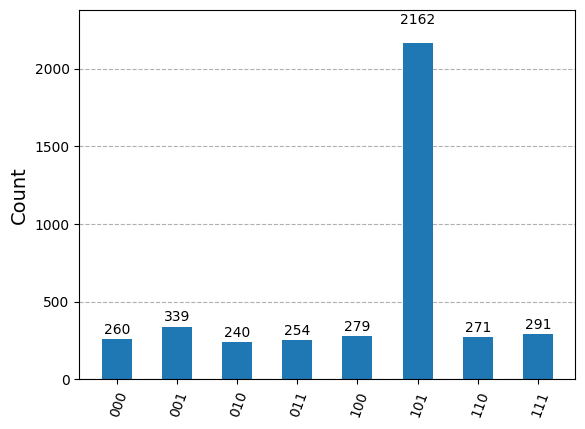

In [ ]:
qc = naive_grover('10110')

# Specify the backend to use
backend = service.backend("ibm_sherbrooke")
sim_backend = AerSimulator.from_backend(backend)

qobj = transpile(qc, sim_backend, optimization_level=3)
result = sim_backend.run(qobj, shots = 4096).result()
counts = result.get_counts()
print(counts)
plot_histogram(counts)

## Run the circuit on a real quantum device (QPU)

In [151]:
# Run our circuit on the backend.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler

# Replace 'YOUR_API_TOKEN' with your actual IBM Quantum API token
token='dfda9ea30f8353753911497de4aaec89e6e4f3a5e7a88149c16fbc2983ed9c8c93cbc6a8c7385930d2af8383b71cc0d6c613562e3d3a4cdc6c05302da8a92b0b'
QiskitRuntimeService.save_account(
  token=token,
  channel="ibm_quantum", # `channel` distinguishes between different account types
  overwrite=True
)

service = QiskitRuntimeService()

In [152]:
# choose the least busy QPU
real_backend = service.least_busy(simulator=False, operational=True)
print(real_backend)
print(real_backend.status())


<IBMBackend('ibm_brisbane')>


In [153]:
qc = naive_grover('1011')

qobj = transpile(qc, real_backend)

# Define Sampler: https://docs.quantum.ibm.com/guides/get-started-with-primitives
sampler = Sampler(mode=real_backend)

# Run calculation
job = sampler.run([qobj])

result = job.result()

Job status: DONE
{'0111': 252, '1011': 252, '0011': 249, '1111': 278, '1100': 259, '1001': 284, '1101': 268, '0000': 239, '0100': 273, '1110': 257, '0110': 232, '1000': 253, '0101': 234, '0001': 283, '1010': 232, '0010': 251}


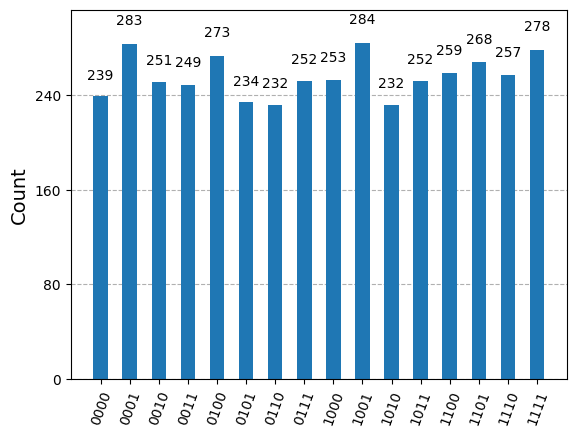

In [154]:
from IPython.display import display


job_status = job.status()
print(f"Job status: {job_status}")

if job_status == 'DONE':
    # Extract counts and plot histogram
    counts = result[0].data['c'].get_counts()
    print(counts)
    
    fig = plot_histogram(counts)
    display(fig)
else:
    print("Job failed to complete successfully.")